In [18]:
import numpy as np

import torch
import torch.nn as nn

import jax.numpy as jnp

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

from kernel_sca_inducing_points import *
from kernels import *
from utils import *

In [26]:
def DDM(mu, sequence_length, sigma=0.35, dt=1, seed=None):
    num_trajectories = len(mu)
    num_steps = int(total_time / dt)
    x = np.zeros((num_trajectories, num_steps + 1))

    for i in range(num_trajectories):
        for t in range(num_steps):
            x[i, t + 1] = x[i, t] + mu[i] * dt + sigma * np.sqrt(dt) * np.random.normal()
    
    p = np.sign(mu)*5                                                                         #p is of shape K, with -1 or 1 based on sign(mu_k)
    x = x[:, :, None]                                                                       #x is K=mu="batch_sz", T, 1
    return torch.tensor(x, dtype=torch.float32), torch.tensor(p, dtype=torch.float32)

def mse_loss(z_all, p):
    zeros = torch.zeros_like(p)
    p_all = torch.stack([zeros, p]).T
    z_comp = torch.stack([z_all[:,0].squeeze(), z_all[:,-1].squeeze()]).T
    return torch.mean((z_comp - p_all) ** 2)
    
class DriftDiffusionRNN(torch.nn.Module):
    def __init__(self, hidden_size, input_size, output_size):
        super(DriftDiffusionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = torch.nn.RNNCell(input_size, hidden_size, nonlinearity='tanh')       #1 --> H=100
        self.fc = torch.nn.Linear(hidden_size, output_size)                             #H=100 --> 1

    def forward(self, x):
        h_i = torch.zeros(x.shape[0], self.hidden_size)                                 #h_i = [K, H=100]
        ls_h_i = []
        ls_z = []
        for i in range(x.shape[1]):
            h_i = self.rnn(x[:, i, :], h_i)
            ls_h_i.append(h_i)
            z = self.fc(h_i)                                                            #momentary evidence z [K,]
            ls_z.append(z)
        #z = torch.tanh(z)
        z_all = torch.stack(ls_z, dim=1)                                                #K, T, 1                                                         
        return z_all, ls_h_i

def train_model(model, optimizer, mu, iterations=10, total_time=50, save_path = 'model.pth'):
    model.train()
    ls_loss = []
    for iter in range(iterations):
        x, p = DDM(mu, total_time)
        optimizer.zero_grad()
        z_all, ls_h_i = model(x)  
        loss = mse_loss(z_all, p)
        loss.backward()
        optimizer.step()

        ls_loss.append(loss.item())
        print(f'Iteration [{iter+1}/{iterations}], Loss: {loss.item():.4f}')
    #torch.save(model.state_dict(), save_path)
    return ls_loss, z_all

mu = np.array([-0.64, -0.32, -0.16, -0.08, -0.04, 0.04, 0.08, 0.16, 0.32, 0.64])  

lr=1e-3
total_time=100
iterations=1500
model = DriftDiffusionRNN(hidden_size=100, input_size=1, output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

ls_loss, z_all = train_model(model, optimizer, mu,  iterations=iterations, total_time=total_time)




Iteration [1/1500], Loss: 14.3325
Iteration [2/1500], Loss: 13.4309
Iteration [3/1500], Loss: 12.2613
Iteration [4/1500], Loss: 11.2961
Iteration [5/1500], Loss: 10.3782
Iteration [6/1500], Loss: 9.3903
Iteration [7/1500], Loss: 8.4536
Iteration [8/1500], Loss: 8.1214
Iteration [9/1500], Loss: 6.9047
Iteration [10/1500], Loss: 7.5340
Iteration [11/1500], Loss: 6.1182
Iteration [12/1500], Loss: 6.2848
Iteration [13/1500], Loss: 6.1562
Iteration [14/1500], Loss: 4.2106
Iteration [15/1500], Loss: 4.7390
Iteration [16/1500], Loss: 4.0589
Iteration [17/1500], Loss: 3.1441
Iteration [18/1500], Loss: 3.2607
Iteration [19/1500], Loss: 3.2822
Iteration [20/1500], Loss: 1.5697
Iteration [21/1500], Loss: 1.5069
Iteration [22/1500], Loss: 3.8275
Iteration [23/1500], Loss: 3.7429
Iteration [24/1500], Loss: 0.9955
Iteration [25/1500], Loss: 0.7935
Iteration [26/1500], Loss: 0.7000
Iteration [27/1500], Loss: 3.3926
Iteration [28/1500], Loss: 4.5954
Iteration [29/1500], Loss: 0.3371
Iteration [30/1500

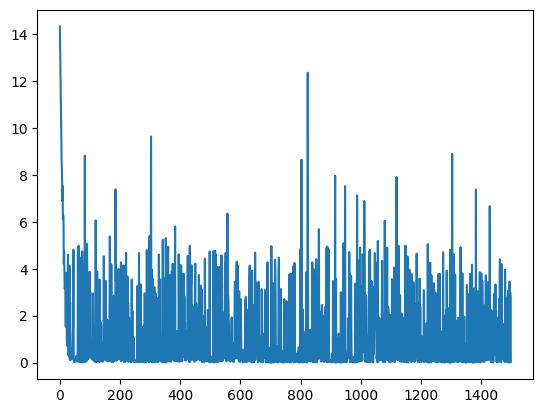

In [27]:
plt.plot(ls_loss)

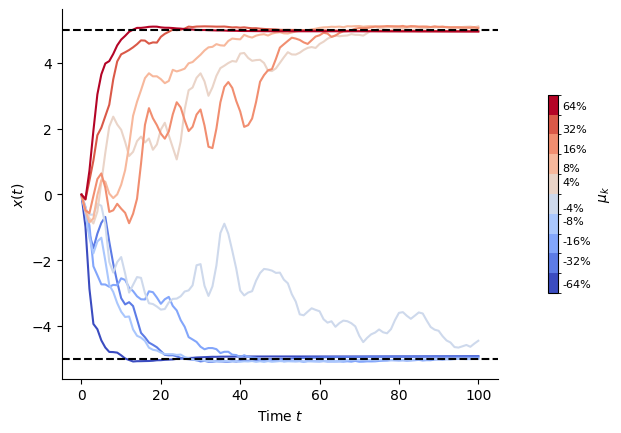

In [29]:
# for i in range(10):
#     plt.plot(z_all[i, :].detach().numpy())

fig, ax = plt.subplots()
boundaries = np.concatenate(([mu[0] - (mu[1] - mu[0])/2], (mu[:-1] + mu[1:])/2, [mu[-1] + (mu[-1] - mu[-2])/2]))
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(mu))
cmap = plt.get_cmap('coolwarm', len(mu))

for i, m in enumerate(mu):
    ax.plot(z_all[i, :].detach().numpy(), color=cmap(norm(m)))

ax.axhline(y=5, color='black', linestyle='--')
ax.axhline(y=-5, color='black', linestyle='--')
ax.set_xlabel('Time $t$')
ax.set_ylabel(r'$x(t)$')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
 
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1, ticks=mu)
cbar.ax.tick_params(size=0) 
cbar.set_label('$\mu_k$')
cbar.set_ticklabels([f'{100*m:.0f}%' for m in mu], fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [30]:
x, p = DDM(mu, sequence_length=50)
z, ls_h_i = model(x)

ls_X = [jnp.array(tensor.detach().numpy()) for tensor in ls_h_i]
X = jnp.stack(ls_X, axis=1).swapaxes(1,2) 
X, _ = pre_processing(X, soft_normalize=None, center=False)
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)          
A = A.reshape(N,-1)   



Iteration 0, S: 0.9470841288566589, S_ratio: 0.20144549012184143
Iteration 10, S: 5.574197292327881, S_ratio: 0.356215238571167
Iteration 20, S: 14.332560539245605, S_ratio: 0.5604758858680725
Iteration 30, S: 26.596174240112305, S_ratio: 0.6318411231040955
Iteration 40, S: 39.37105941772461, S_ratio: 0.6811521649360657
Iteration 50, S: 55.690025329589844, S_ratio: 0.6912796497344971
Iteration 60, S: 82.1647720336914, S_ratio: 0.6830998659133911
Iteration 70, S: 100.2403564453125, S_ratio: 0.7000210285186768
Iteration 80, S: 128.27456665039062, S_ratio: 0.648068368434906
Iteration 90, S: 131.2757110595703, S_ratio: 0.5925427079200745
Iteration 100, S: 162.1348419189453, S_ratio: 0.6043488383293152
Iteration 110, S: 206.90399169921875, S_ratio: 0.4850645661354065
Iteration 120, S: 244.55599975585938, S_ratio: 0.4489167034626007
Iteration 130, S: 248.57362365722656, S_ratio: 0.3936065435409546
Iteration 140, S: 274.2392578125, S_ratio: 0.4270685911178589
Iteration 150, S: 278.57904052734

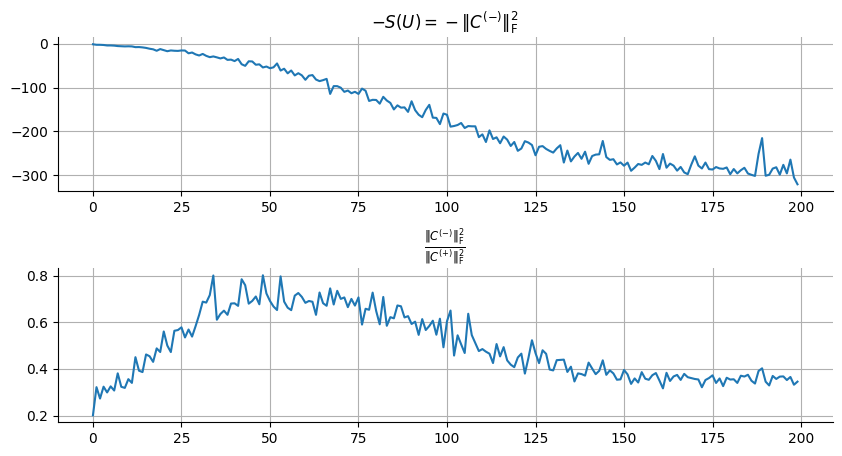

In [31]:

kernel_function=K_X_Y_squared_exponential
d = 2
c = 30
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=200, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio )

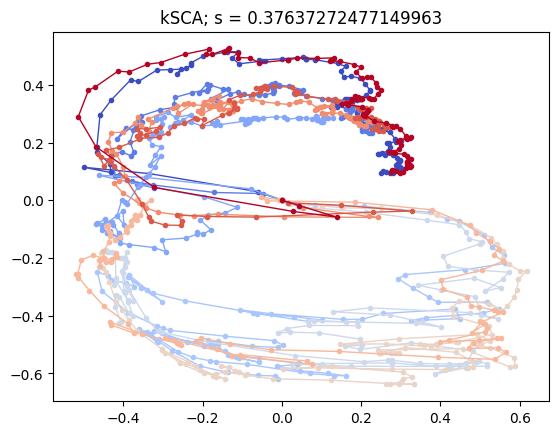

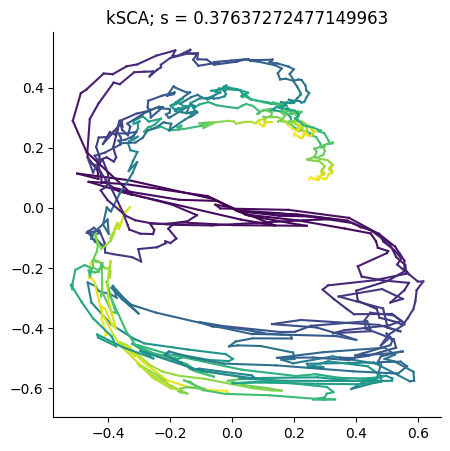

<Figure size 640x480 with 0 Axes>

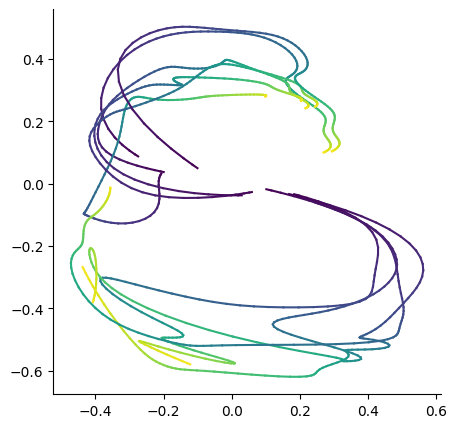

In [32]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, _, _, _  = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

fig = plt.figure()
ax = fig.add_subplot(111) #projection='3d'
cmap = plt.get_cmap('coolwarm', K)
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]

    color = cmap(k / (K - 1)) 
    ax.plot(x, y, linestyle='-', marker='.', linewidth=1, color=color)
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')


plot_2D(Y[:,:,:])
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

Y_smoothed = apply_gaussian_smoothing(Y, sigma=4)
plt.figure()
plot_2D(Y_smoothed)